In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
os.sys.path.append(os.path.dirname(os.path.abspath('.')))

# Import local modules
from src.evaluation.evaluation import mse, r_squared
from src.resampling.resampling import K_fold_splitter

In [2]:
df_X = pd.read_csv('../data/generated/X.csv', index_col=0)
df_z_no_noise = pd.read_csv('../data/generated/no_noise.csv', usecols=[1])
df_z_some_noise = pd.read_csv('../data/generated/some_noise.csv', usecols=[1])
df_z_noisy = pd.read_csv('../data/generated/noisy.csv', usecols=[1])

X = np.array(df_X)
z_no_noise = np.array(df_z_no_noise).ravel()
z_some_noise = np.array(df_z_some_noise).ravel()
z_noisy = np.array(df_z_noisy).ravel()

In [3]:
k = 10 # Number of folds, for cross-validation
min_lambda = 0.001
max_lambda = 0.01
no_lambdas = 100
lambda_values = list(np.linspace(min_lambda, max_lambda, no_lambdas))
targets = [{
    'name': 'No noise',
    'values': z_no_noise,
    'mse_values': np.zeros(no_lambdas)
},
{
    'name': 'Some noise (sigma 0.1)',
    'values': z_some_noise,
    'mse_values': np.zeros(no_lambdas)
},
{
    'name': 'Noisy (sigma 0.4)',
    'values': z_noisy,
    'mse_values': np.zeros(no_lambdas)
}]

col_names = ['MSE']
output_df = pd.DataFrame(columns=col_names)
# print('%-30s|%-10s' %('', 'MSE'))

# print('-'*50)

for target in targets:
    for l, lambda_value in enumerate(lambda_values):
        # print('Lambda', lambda_value)
        mse_values = np.zeros(k)
        z = target['values']
        lasso = Lasso(lambda_value)
    
        kfs = K_fold_splitter(X.shape[0], k)
        fold_indices = kfs.cross_val_split()
    
        for j, fold in enumerate(fold_indices):     
            X_train = X[fold['train_indices']]
            z_train = z[fold['train_indices']]
            X_test = X[fold['test_indices']]
            z_test = z[fold['test_indices']]
        
            lasso.fit(X_train, z_train)
            predictions = lasso.predict(X_test)
            mean_squared_error = mse(z_test, predictions)
        
            mse_values[j] = mean_squared_error
    
        mse_value = np.mean(mse_values)
        target['mse_values'][l] = mse_value

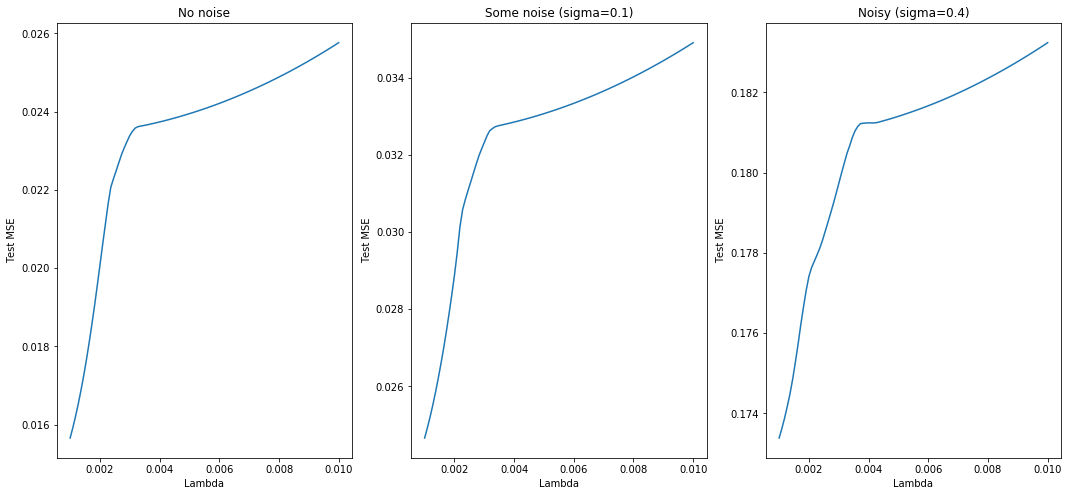

In [4]:
plt.figure(figsize=(18, 8))
plt.subplot(131)
plt.plot(lambda_values, targets[0]['mse_values'])
plt.title('No noise')
plt.xlabel('Lambda')
plt.ylabel('Test MSE')
plt.subplot(132)
plt.plot(lambda_values, targets[1]['mse_values'])
plt.title('Some noise (sigma=0.1)')
plt.xlabel('Lambda')
plt.ylabel('Test MSE')
plt.subplot(133)
plt.plot(lambda_values, targets[2]['mse_values'])
plt.title('Noisy (sigma=0.4)')
plt.xlabel('Lambda')
plt.ylabel('Test MSE')
plt.show()

It seems as if the MSE grows more or less monotonically as lambda increases. The shrinkage parameter does not lead to a better test MSE in these particular cases.